In [1]:
import torch
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

from scarches.dataset.trvae.data_handling import remove_sparsity
from lataq.models import TRANVAE
from lataq.exp_dict import EXPERIMENT_INFO

sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

%load_ext autoreload
%autoreload 2

In [2]:
PARAMS = {
    'EPOCHS': 50,                                      #TOTAL TRAINING EPOCHS
    'N_PRE_EPOCHS': 30,                                #EPOCHS OF PRETRAINING WITHOUT LANDMARK LOSS
    'DATA_DIR': '../../lataq_reproduce/data',          #DIRECTORY WHERE THE DATA IS STORED
    'DATA': 'pancreas',                                #DATA USED FOR THE EXPERIMENT
    'EARLY_STOPPING_KWARGS': {                         #KWARGS FOR EARLY STOPPING
        "early_stopping_metric": "val_landmark_loss",  ####value used for early stopping
        "mode": "min",                                 ####choose if look for min or max
        "threshold": 0,
        "patience": 20,
        "reduce_lr": True,
        "lr_patience": 13,
        "lr_factor": 0.1,
    },
    'LABELED_LOSS_METRIC': 'hyperbolic',           
    'UNLABELED_LOSS_METRIC': 'hyperbolic',
    'LATENT_DIM': 2,
    'ALPHA_EPOCH_ANNEAL': 1e3,
    'CLUSTERING_RES': 2,
    'HIDDEN_LAYERS': 3,
    'ETA': 1,
}

In [3]:
EXP_PARAMS = EXPERIMENT_INFO[PARAMS['DATA']]
adata = sc.read(
    f'{PARAMS["DATA_DIR"]}/{EXP_PARAMS["file_name"]}'
)
condition_key = EXP_PARAMS['condition_key']
cell_type_key = EXP_PARAMS['cell_type_key']
reference = EXP_PARAMS['reference']
query = EXP_PARAMS['query']
adata.obs['query'] = adata.obs[condition_key].isin(query)
adata.obs['query'] = adata.obs['query'].astype('category')
source_adata = adata[adata.obs.study.isin(reference)].copy()
target_adata = adata[adata.obs.study.isin(query)].copy()

In [4]:
lataq_model = TRANVAE(
    adata=source_adata,
    condition_key=condition_key,
    cell_type_keys=cell_type_key,
    hidden_layer_sizes=[128]*int(PARAMS['HIDDEN_LAYERS']),
    latent_dim=PARAMS['LATENT_DIM'],
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 4000 128 7
	Hidden Layer 1 in/out: 128 128
	Hidden Layer 2 in/out: 128 128
	Mean/Var Layer in/out: 128 2
Decoder Architecture:
	First Layer in, out and cond:  2 128 7
	Hidden Layer 1 in/out: 128 128
	Hidden Layer 2 in/out: 128 128
	Output Layer in/out:  128 4000 



In [5]:
lataq_model.train(
    n_epochs=PARAMS['EPOCHS'],
    pretraining_epochs=PARAMS['N_PRE_EPOCHS'],
    early_stopping_kwargs=PARAMS['EARLY_STOPPING_KWARGS'],
    alpha_epoch_anneal=PARAMS['ALPHA_EPOCH_ANNEAL'],
    eta=PARAMS['ETA'],
    clustering_res=PARAMS['CLUSTERING_RES'],
    labeled_loss_metric=PARAMS['LABELED_LOSS_METRIC'],
    unlabeled_loss_metric=PARAMS['UNLABELED_LOSS_METRIC'],
    hyperbolic_log1p=False,
)

 |████████████████████| 100.0%  - val_loss: 1006.0606467507 - val_trvae_loss: 1005.8410700018 - val_landmark_loss: 0.2195786685 - val_labeled_loss: 0.2195786685
Saving best state of network...
Best State was in Epoch 47


In [6]:
data_latent = lataq_model.get_latent(
    x=source_adata.X, 
    c=source_adata.obs[condition_key], 
    hyperbolic=True
)

adata_latent = sc.AnnData(data_latent)
adata_latent.obs[condition_key] = source_adata.obs[condition_key].tolist()
adata_latent.obs['cell_type'] = source_adata.obs['cell_type'].tolist()

/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


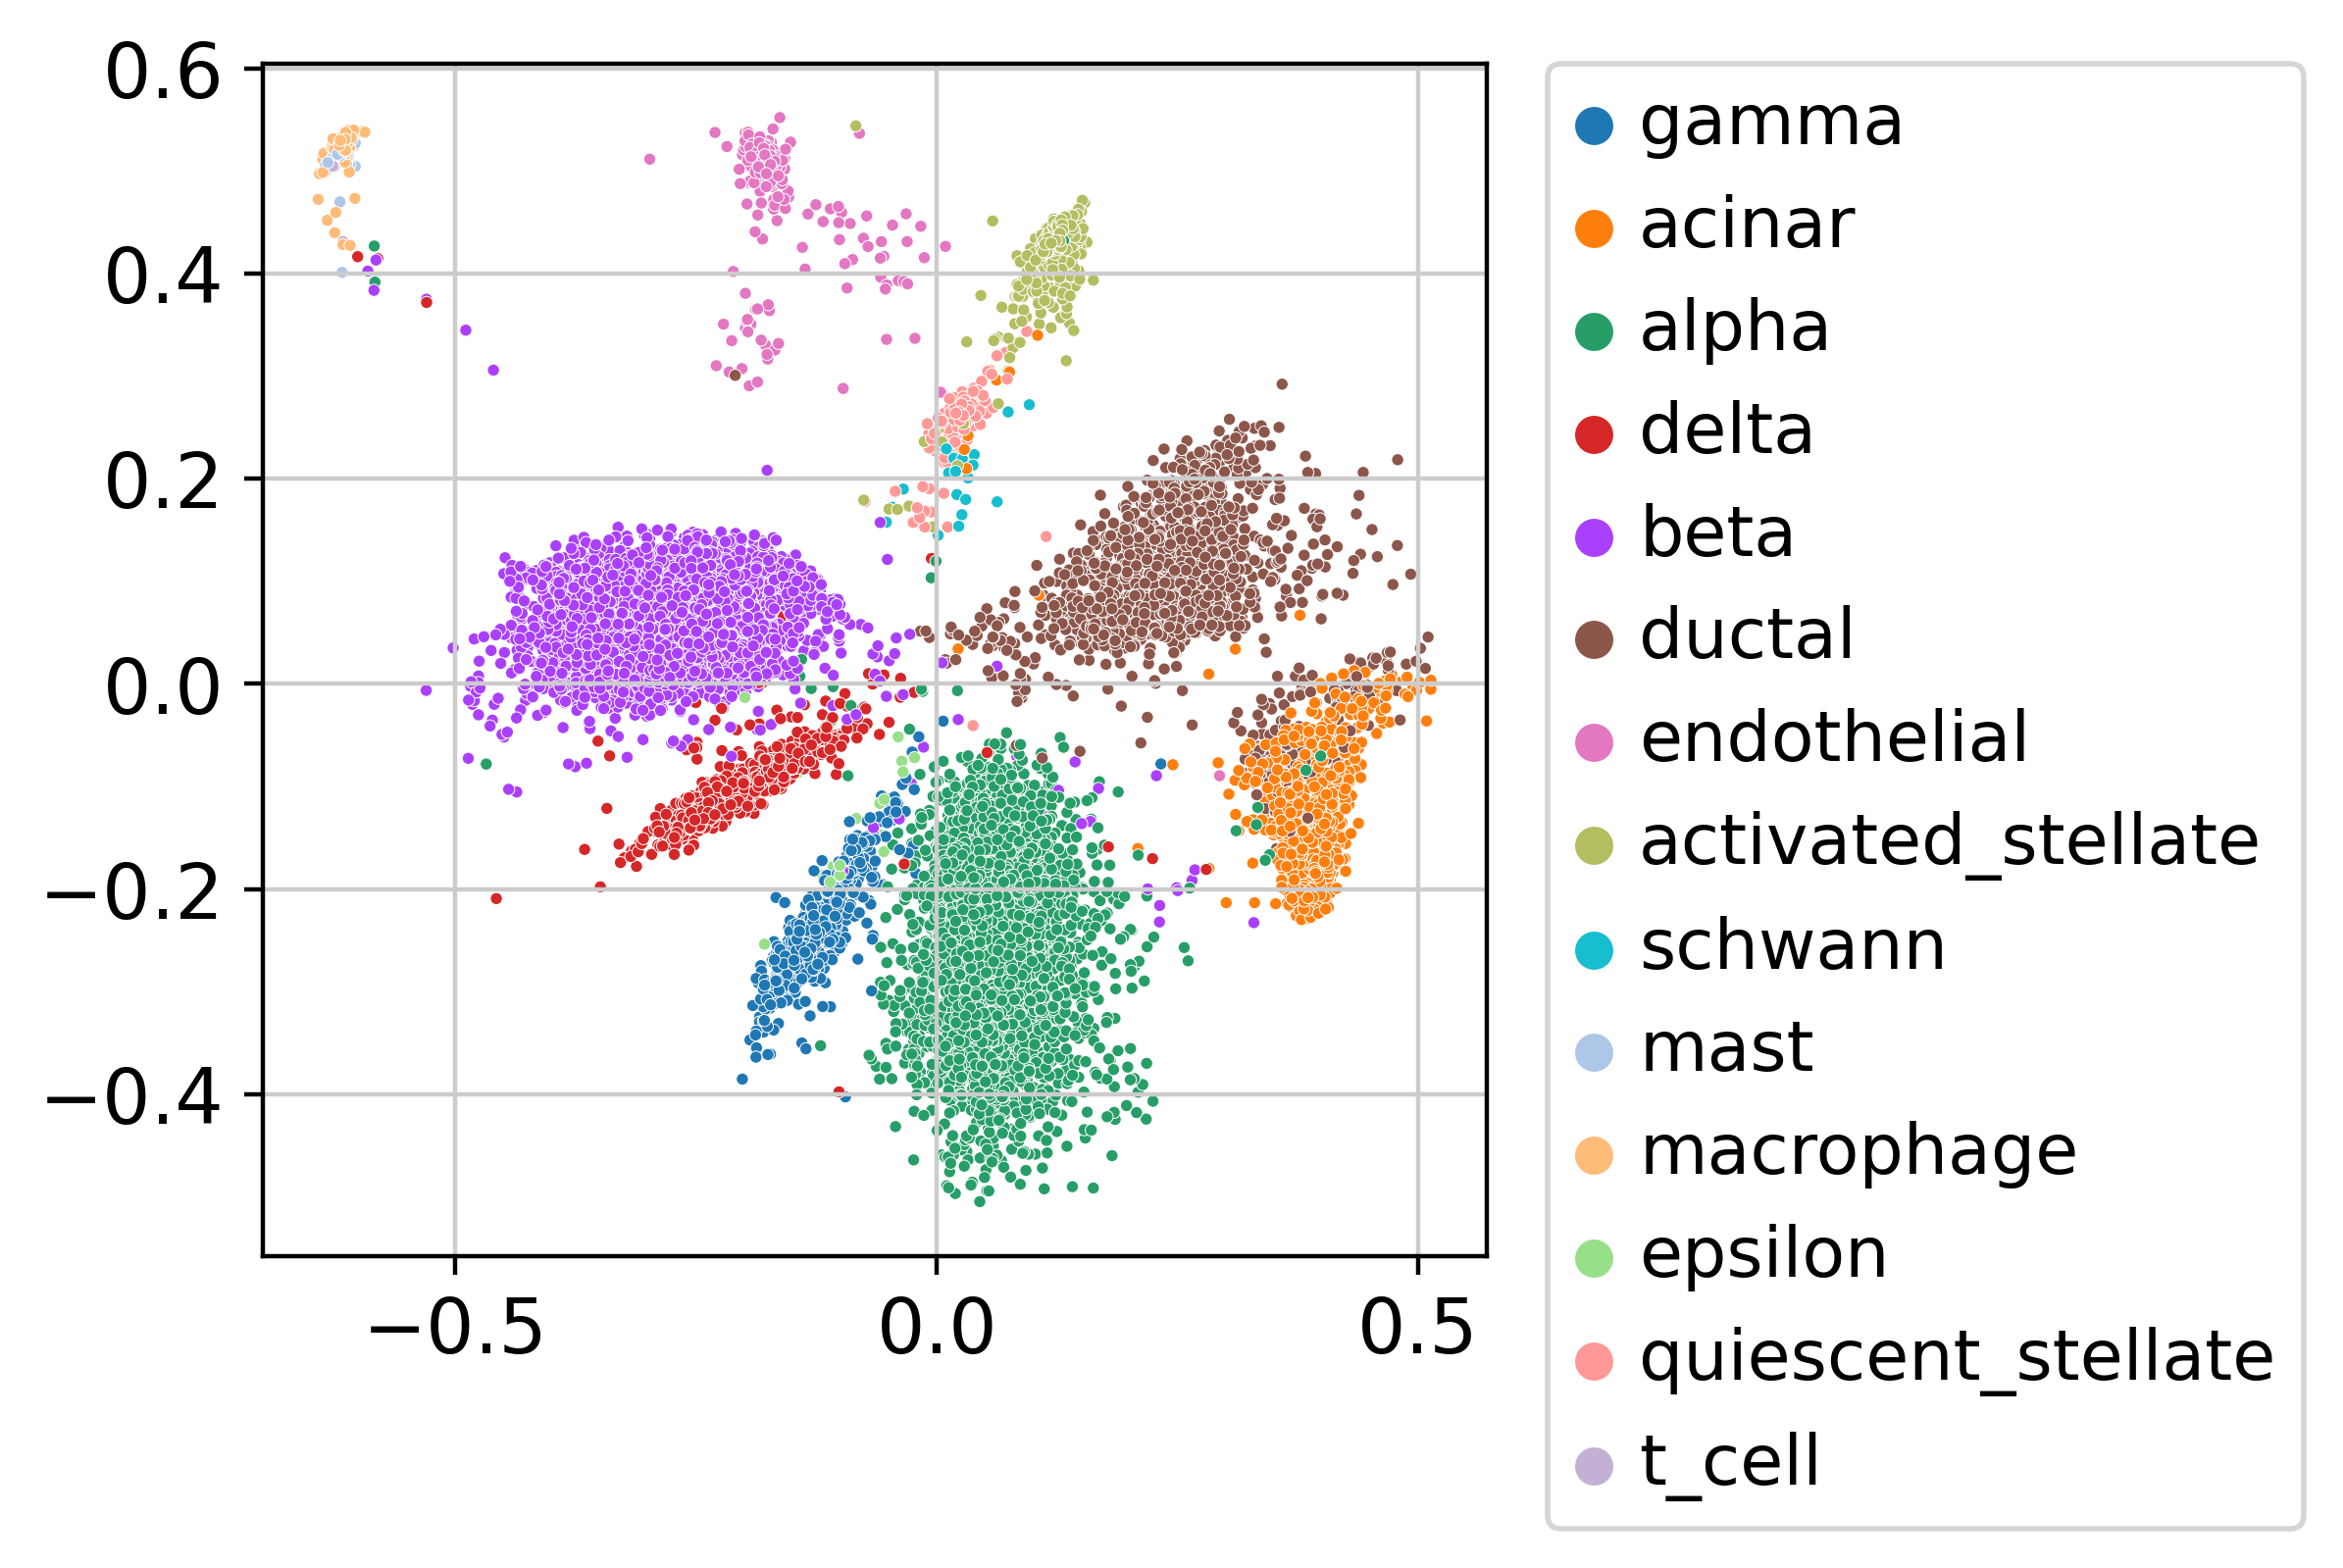

In [7]:
sns.scatterplot(adata_latent.X[:, 0], adata_latent.X[:, 1], hue=adata_latent.obs['cell_type'], s=5)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)